In [1]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source("cleanup.R") 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

__Question 1: Data Description__

* Number of Observations: 196
* Number of Variables: 7
 
  __Types of Variables:__
* categorical
* logical
* numerical
* character

__Names of Variables:__
* Experience: Is the player an amateaur, beginner, pro, regular, or veteran? 
* Age: Player age
* Gender: Player gender
* Subscribe: Is the player subscribed to the newsletter?
* Played Hours: Hours spent playing
* Hashed Email: Player email
* Name: Player name

__Summary Statistics:__

_Age:_
* Mean age: 20.5 
* Median age: 19
* Minimum age: 8
* Maximum age: 50
  
_Hours Played:_
* Mean hours played: 5.91
* Median hours played: 0.10
* Minimum hours played: 0
* Maximum hours played: 233.1

__Method of Data Collection:__
A MineCraft serverLinks was set up to an external site, where players' actions were recorded as they navigated through the world. 

__Question 2: Questions__


_Broad question being addressed:_ "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?"


_Specific question formulated:_ "Are player age and hours played predictive of whether a player subcribes to a game related newsletter?"

To investigate this question, the players_csv data will be useful. The data includes experience, a categorical variable, and age, which is expected to be a useful predictor of subscription behavior, as younger or older players may have different engagement patterns. Another useful variable is the played_hours variable, which may be a strong predictor of subscription behaviour because it will tell us how engaged a player is with the game. Finally, the data includes the variable subscribe, which is the target variable (binary: 1 = subscribed, 0 = not subscribed). This is what we're trying to predict, based on the numerous predictor variables in the data set. 


To wrangle the data and use it to address the question, there are a number of steps that need to be taken. The sessions data and players data needs to be read in, and have all NA's accounted for by removing them. From the sessions data, new variables must be created. The first variable will be Session Duration, calculated by subtracting start time from end time and creating a new column. A column titled Session Frequency must also be created, calculated by adding the number of sessions of each player. Lastly, the converstion of categorical variables into numerical variables must be done in order for the KNN-classification model to be successful. 

**Question 3: Exploratory Data Analysis and Visualization:**

In [41]:
players_csv <- read_csv("data/players.csv")

players_csv

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [42]:
#this converts the object "players_csv" into a data frame, ensuring that it is one

players_df <- as.data.frame(players_csv)
players_df

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [43]:
#this removes all NA values and cleans up the data frame
players_cleaned <- na.omit(players_df)
players_cleaned


,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
193,Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
194,Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
195,Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


In [44]:
players_stats <- summary(players_cleaned)

players_stats

  experience        subscribe       hashedEmail         played_hours    
 Length:194         Mode :logical   Length:194         Min.   :  0.000  
 Class :character   FALSE:52        Class :character   1st Qu.:  0.000  
 Mode  :character   TRUE :142       Mode  :character   Median :  0.100  
                                                       Mean   :  5.905  
                                                       3rd Qu.:  0.600  
                                                       Max.   :223.100  
     name              gender               Age       
 Length:194         Length:194         Min.   : 8.00  
 Class :character   Class :character   1st Qu.:17.00  
 Mode  :character   Mode  :character   Median :19.00  
                                       Mean   :20.52  
                                       3rd Qu.:22.00  
                                       Max.   :50.00  

In [45]:
num_obs <- nrow(players_df)
num_vars <- ncol(players_df)

num_obs
num_vars

[1] 196

[1] 7

Okay! We know that there are __196__ observations (rows) and __7__ variables (columns). Now we will figure out the names and types of variables.

In [47]:
mean_table <- players_df %>%
  summarise_all(~if(is.numeric(.)) mean(., na.rm = TRUE) else NA) |>
          select(Age, played_hours)
mean_table

Age,played_hours
<dbl>,<dbl>
20.52062,5.845918


The above cell shows the mean values of the two numerical variables in a table, Age and played_hours. The mean value for Age is __20.5__ and the mean value for played_hours is __5.85__.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


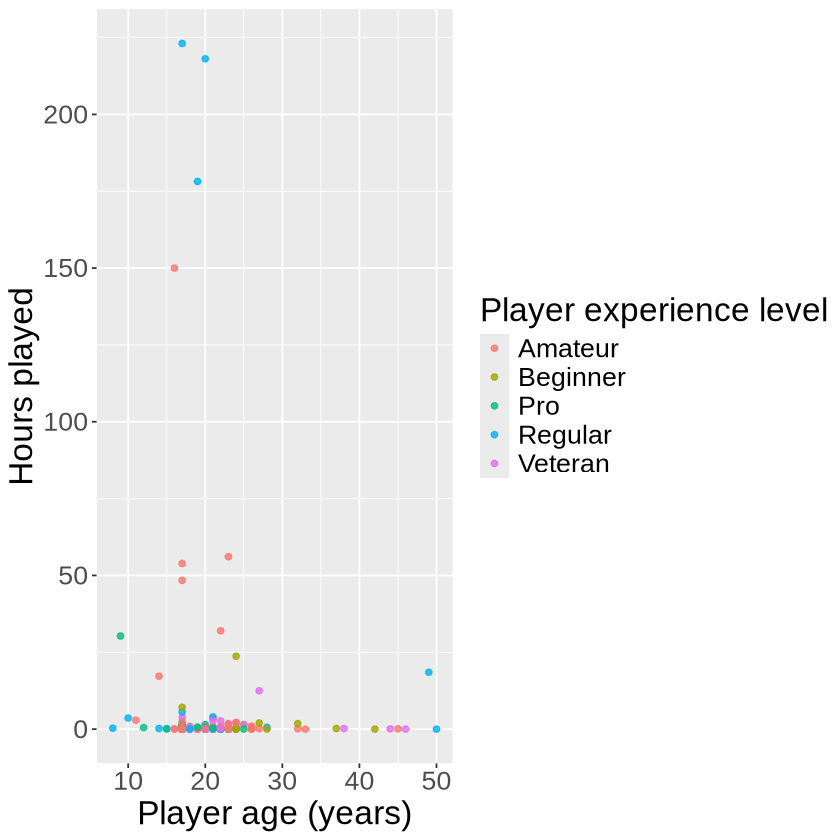

In [76]:
players_plot <- players_df |>
    ggplot(aes(x = Age, y = played_hours, color = experience)) +
     geom_point(alpha = 0.8) +
    labs(x = "Player age (years)", y = "Hours played", color = "Player experience level") +
    theme(text = element_text(size = 20)) 
players_plot

This graph investigates the relationship between hours played, player age, and their experience level. This could be useful for a KNN-model to figure out if player age and hours played are predictive of their experience level.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


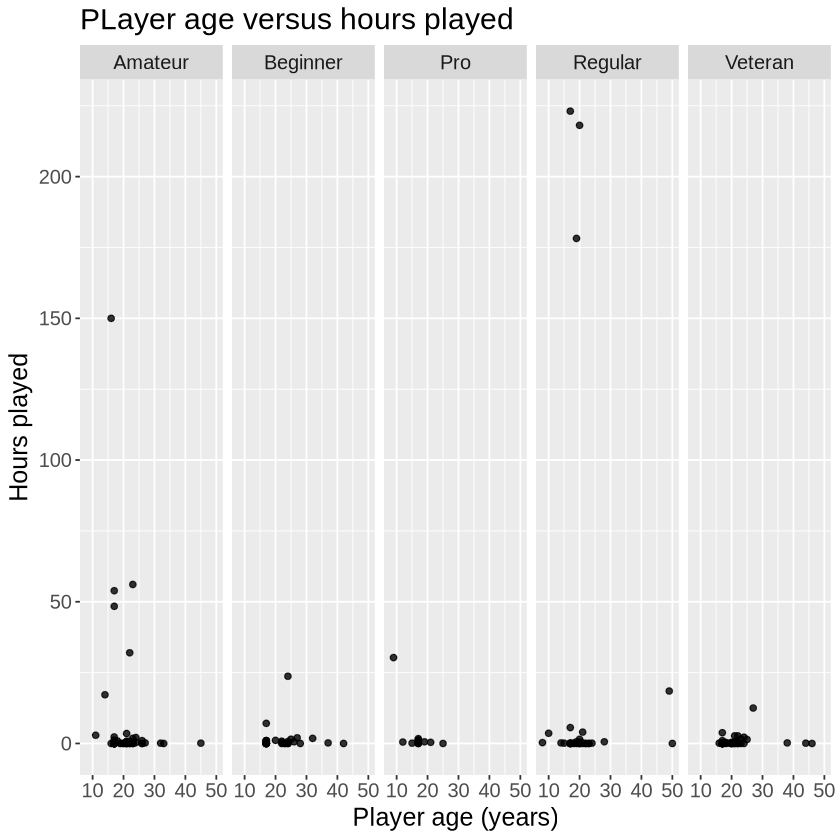

In [78]:
players_plot_2 <- players_df |>
    ggplot(aes(x = Age, y = played_hours)) +
     geom_point(alpha = 0.8) +
    facet_grid(cols = vars(experience))+
    labs(x = "Player age (years)", y = "Hours played") +
    theme(text = element_text(size = 15)) +
    ggtitle("Player age versus hours played")
    
players_plot_2

The above plot investigates the relationship between player age and hours played. Each graph is separated to player experience level. Upon looking at the graphs, there does not seem to be a strong relationship between hours played, player age, and their experience level. This is useful to know, as we may not consider all hours played and character age to be predictor variables of experience level during KNN-classification.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


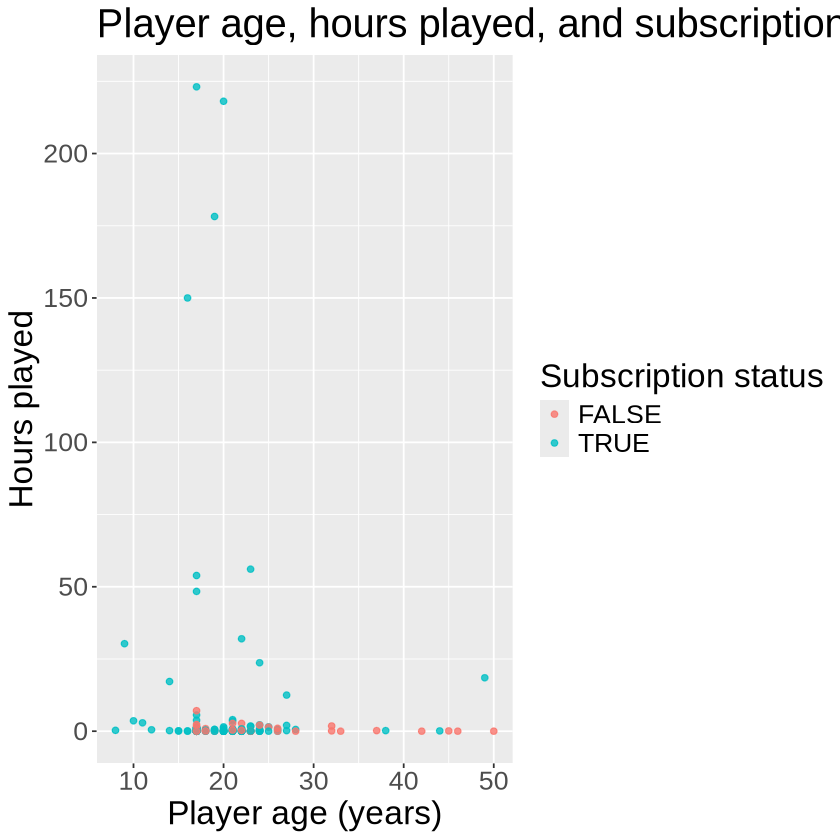

In [100]:
players_plot_3 <- players_df |>
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
     geom_point(alpha = 0.8) +
    labs(x = "Player age (years)", y = "Hours played", color = "Subscription status") +
    theme(text = element_text(size = 20)) +
    ggtitle("Player age, hours played, and subscription status")
players_plot_3
           

The above graph explores the relationship hours played, player age, and subscription status. Based on the number of outliers, hours played do not seem to be a good predictor variable. We might instead consider a graph that uses only player age or hours played to predict subscription status. 

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


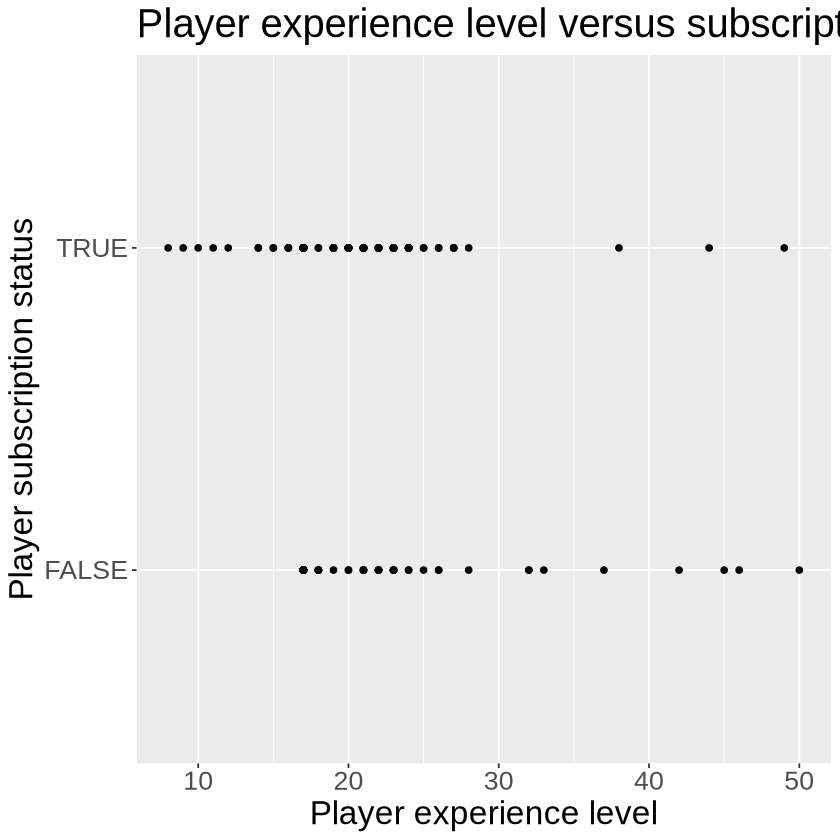

In [103]:
players_plot_4 <- players_df |>
    ggplot(aes(x = Age, y = subscribe)) +
    geom_point() +
    labs(x = "Player experience level", y = "Player subscription status") +
    theme(text = element_text(size = 20)) +
    ggtitle("Player experience level versus subscription status")

players_plot_4

This graph is not very useful in deciphering a relationship between subscription status and player experience level, because the variables do not work as independant and dependant variables.

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_count()`).”


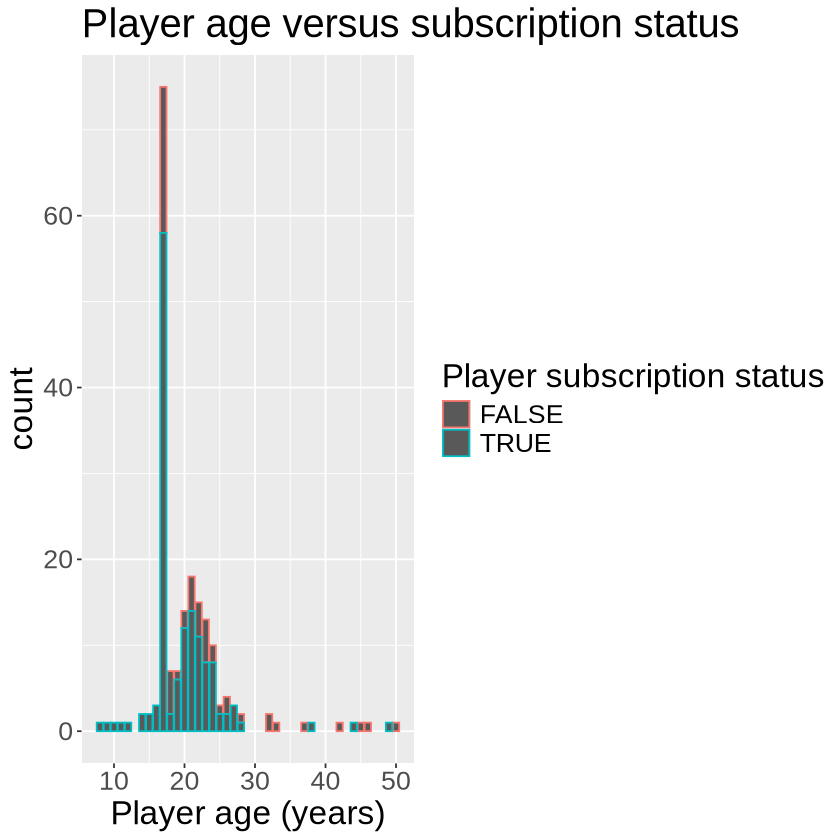

In [104]:
players_plot_5 <- players_df |>
    ggplot(aes(x = Age, color = subscribe)) +
    geom_bar() +
    labs(x = "Player age (years)", color = "Player subscription status") +
    theme(text = element_text(size = 20)) + 
    ggtitle("Player age versus subscription status")
players_plot_5

This graph investigates the relationship between player age and player subscription status. This could be useful in deciphering if there is a strong relationship between the two.

Based on all the above graphs, it is clear that since player age and hours played are the only numerical variables, they are the only variables that make sense to plot on the x and y axis. Subscription status and player experience level make sense to differentiate as colors on the graphs. 

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


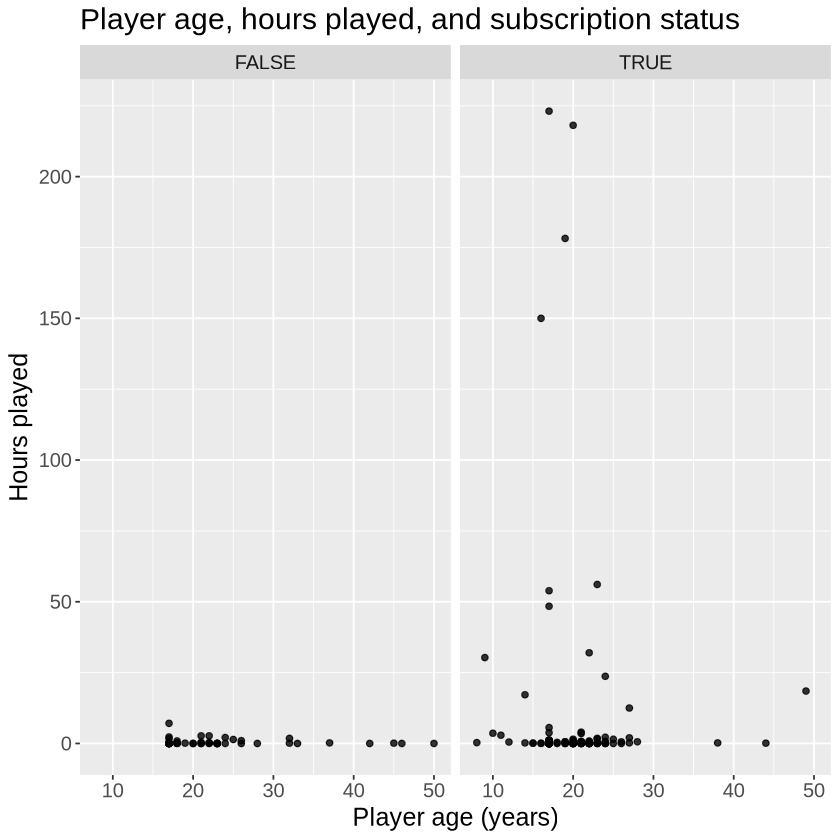

In [107]:
players_plot_6 <- players_df |>
    ggplot(aes(x = Age, y = played_hours)) +
     geom_point(alpha = 0.8) +
    facet_grid(cols = vars(subscribe))+
    labs(x = "Player age (years)", y = "Hours played") +
    theme(text = element_text(size = 15)) +
    ggtitle("Player age, hours played, and subscription status")
    
players_plot_6

**Question 4: Methods and Plan:**

*Proposed Method: K-Nearest Neighbors (KNN) Classification*


This method is appropriate because the target variable, subscribe, is binary (1 = subscribed, 0 = not subscribed). KNN is well-suited for binary classification tasks as it categorizes instances based on the majority class of their nearest neighbors in the feature space. It is also appropriate because KNN is a non-parametric method, meaning it does not make assumptions about the data distribution. Because KNN relies on distance metrics, we must scale the data. We must also be careful in our selection of k. Weaknesses and limitations may occur from the size of the data set, and any outliers that may be in the data set. To avoid overfitting or underfitting, we will apply cross-validation. Cross-validation helps ensure that the model is generalizing well to unseen data and is not just memorizing the training data. We will also experiment with different values of k to find the optimal number of neighbours, choosing the one that gives the highest cross-validated accuracy. The data will need to be split into training and testing sets, with a 70/30 split. Categorical variables will need to be encoded as numerical variables. All numerical features will be scaled to have a mean of 0 and a standard deviation of 1.
